In [ ]:
pip install sklearn matplotlib

In [ ]:
pip install transformers

In [ ]:
import os
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")

In [ ]:
# Function to get model's prediction
def get_model_prediction(text):
    tokenized_inputs = tokenizer(text, truncation=True, return_tensors='pt', max_length=512)
    inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
    outputs = model(**inputs)
    logits = outputs[0]
    probs = logits.softmax(dim=-1)[0].tolist()


    stance_mapping = {0: "left", 1: "center", 2: "right"}
    predicted_stance = stance_mapping[probs.index(max(probs))]

    return predicted_stance

In [ ]:

# Load JSON files from the directory
data_dir = "/data"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')]

true_labels = []
predicted_labels = []

for file in tqdm(all_files):
    with open(file, 'r') as f:
        article = json.load(f)

    title = article['title']
    body = " ".join([sent['sentence'] for sent in article['body']])

    # Combine title and body
    full_text = title + " " + body

    true_labels.append(article['article-level-annotations']['stance'].lower())
    predicted_labels.append(get_model_prediction(full_text))

100%|██████████| 300/300 [12:19<00:00,  2.46s/it]


In [ ]:
# Total true labels

df_Labels = pd.DataFrame(true_labels)
print(df_Labels.value_counts())

center    144
left       81
right      75
dtype: int64


In [ ]:
# Create a DataFrame to compare labels
df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})

# Evaluate the model's performance
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(true_labels, predicted_labels))

Accuracy: 0.4733
              precision    recall  f1-score   support

      center       0.50      0.69      0.58       144
        left       0.27      0.15      0.19        81
       right       0.54      0.41      0.47        75

    accuracy                           0.47       300
   macro avg       0.44      0.42      0.41       300
weighted avg       0.45      0.47      0.45       300



<Figure size 1000x700 with 0 Axes>

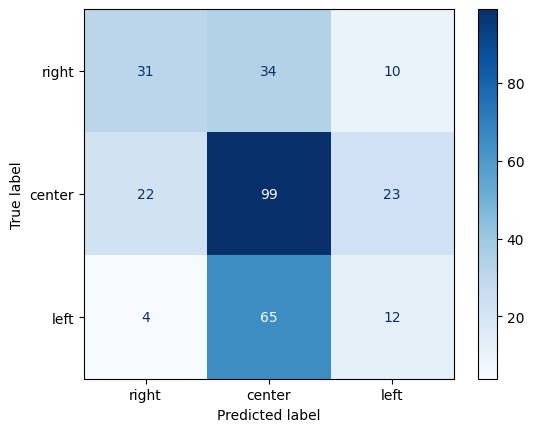

In [ ]:
# Compute confusion matrix
matrix = confusion_matrix(df['True_Labels'], df['Predicted_Labels'], labels=list(set(true_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(set(true_labels)))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Accuracy with only title**

In [ ]:
# Function to get model's prediction
def get_model_prediction(text):
    inputs = tokenizer(text,  return_tensors='pt')
    probs_list = []
    outputs = model(**inputs)
    logits = outputs[0]
    probs = logits.softmax(dim=-1)[0].tolist()
    probs_list.append(probs)

    # Averaging predictions across chunks
    avg_probs = [sum(col) / len(col) for col in zip(*probs_list)]

    # Mapping highest probability to its stance
    stance_mapping = {0: "left", 1: "center", 2: "right"}
    predicted_stance = stance_mapping[avg_probs.index(max(avg_probs))]

    return predicted_stance

true_labels = []
predicted_labels = []

for file in tqdm(all_files):
    with open(file, 'r') as f:
        article = json.load(f)

    title = article['title']


    true_labels.append(article['article-level-annotations']['stance'].lower())
    predicted_labels.append(get_model_prediction(title))


# Create a DataFrame to compare labels
df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})

# Evaluate the model's performance
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(true_labels, predicted_labels))

100%|██████████| 300/300 [00:42<00:00,  7.05it/s]

Accuracy: 0.3400
              precision    recall  f1-score   support

      center       0.43      0.30      0.35       144
        left       0.33      0.20      0.25        81
       right       0.28      0.57      0.38        75

    accuracy                           0.34       300
   macro avg       0.35      0.36      0.33       300
weighted avg       0.37      0.34      0.33       300



<Figure size 1000x700 with 0 Axes>

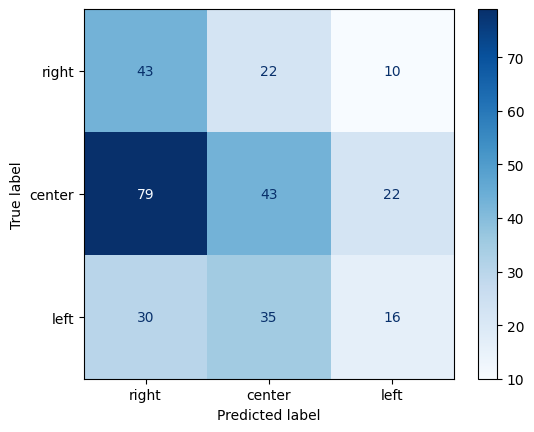

In [ ]:
# Compute confusion matrix
matrix = confusion_matrix(df['True_Labels'], df['Predicted_Labels'], labels=list(set(true_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(set(true_labels)))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.show()